In [1]:
%conda install -c conda-forge matplotlib 
%conda install -c anaconda scipy
!pip install tqdm h5py zarr pillow numpy imgaug==0.4.0 mahotas #imgaug has dependency on previous packages
!pip install scikit-image
!pip install tensorboard
!pip install torchsummary

Solving environment: done

## Package Plan ##

  environment location: /home/xiaoyan/anaconda3/envs/07_instance_segmentation

  added / updated specs:
    - matplotlib


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2021.5.30-ha878542_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Solving environment: done

## Package Plan ##

  environment location: /home/xiaoyan/anaconda3/envs/07_instance_segmentation

  added / updated specs:
    - scipy


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2021.5.3~ --> anaconda::ca-certificates-2020.10.14-0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import glob
import os
import zarr
import random
import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import h5py
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.colormap import *
from unet_fov import *
from utils.disc_loss import DiscriminativeLoss
from utils.mean_shift import MeanShift
from skimage import measure
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

Tile and Stitch
==================================

When applying one of our deep learning models on microscopy data, it might be that the images are too big to be stored on the GPU and predicted at once. In such situations, the image is subdivided into **tiles**, the **tiles** are fed into the DL model and the respective predictions are stitched together to form an image of the same resolution as the original microscopy image that was subject to inference. 

For a more detailed reference, please see https://arxiv.org/pdf/2101.05846.pdf


Data
-------
For this task we use again a subset of the data used in the kaggle data science bowl 2018 challenge
(https://www.kaggle.com/c/data-science-bowl-2018/)

![image.png](utils/attachment/image.png)
All images show nuclei recorded using different microscopes and lighting conditions.
There are 30 images in the training set, 8 in the validation set and 16 in the test set.

In [3]:
# decompress data
from shutil import unpack_archive
unpack_archive(os.path.join('datasets','data_kaggle.tar.gz'), './')

In [3]:
class KaggleDSB_dataset(Dataset):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the torch dataset class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images.
        data_type (string): train/val/test, select subset of images
        prediction_type (string): default to be "metric_learning" for this notebook
        net_input_size (list): the input title size of you UNet
        padding_size (int): the number of pixels to pad on each side of the image before augmentation and cropping
        cache: if cache the data, default: False
    """
    def __init__(self,
                 root_dir,
                 data_type,
                 prediction_type="two_class",
                 net_input_size=None,
                 padding_size=None,
                 cache = False
                ):
        self.data_type = data_type
        self.files = glob.glob(os.path.join(root_dir, data_type, "*.zarr"))
        self.prediction_type = prediction_type
        self.net_input_size = net_input_size
        self.padding_size = padding_size
        self.define_augmentation()
        self.cache = cache
        if cache:
            self.cached_data = [self.load_sample(filename) for filename in self.files]

    def __len__(self):
        return len(self.files)
    
    def define_augmentation(self):
        
        self.transform = iaa.Identity
        self.crop = None
        self.pad = None

        self.transform = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-45, 45), cval=(0,0), mode="constant"),  # rotate by -45 to 45 degrees (affects segmaps)
            iaa.geometric.ElasticTransformation(alpha=(20.0, 20.0), sigma=(5.0, 5.0)),
        ], random_order=True)
        
        if self.net_input_size is not None:
            self.crop = iaa.CropToFixedSize(width=self.net_input_size[1], height=self.net_input_size[0])
            
        if self.padding_size is not None:
            self.pad = iaa.Pad(px=(self.padding_size, self.padding_size, self.padding_size, self.padding_size),
                               keep_size=False)
        
    def get_filename(self, idx):
        return self.files[idx]
        
    def __getitem__(self, idx):
        if self.cache:
            raw, label = self.cached_data[idx]
        else:
            fn = self.get_filename(idx)
            raw, label = self.load_sample(fn)
        raw = self.normalize(raw)
        # augment for training
        if self.padding_size is not None:
            raw = self.pad(images = raw) # CHW -> CHW
            label = self.pad(images = label) # CHW -> CHW
        if self.data_type == "train":
            raw = np.transpose(raw, [1,2,0]) # CHW -> HWC
            label = np.transpose(label, [1,2,0]) # CHW -> HWC            
            raw, label = self.augment_sample(raw, label) # HWC -> HWC
            raw = np.transpose(raw, [2,0,1]) # HWC -> CHW
            label = np.transpose(label, [2,0,1]) # HWC -> CHW
        if self.net_input_size is not None:
            tmp = np.concatenate([raw, label], axis = 0).copy() # C1+C2 HW
            tmp = np.transpose(tmp, [1,2,0]) # CHW -> HWC 
            tmp = self.crop.augment_image(tmp) # HWC -> HWC
            tmp = np.transpose(tmp, [2,0,1])
            raw, label = np.expand_dims(tmp[0], axis=0), np.stack(tmp[1:],axis=0) # split
        raw, label = torch.Tensor(raw), torch.Tensor(label)
        return raw, label
    
    def augment_sample(self, raw, label):
        # stores float label (sdt) differently than integer label (rest)
        if self.prediction_type in ["sdt"]:
            label = HeatmapsOnImage(label, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, label = self.transform(image=raw, heatmaps=label)
        else:
            label = label.astype(np.int32)
            label = SegmentationMapsOnImage(label, shape=raw.shape)
            raw, label = self.transform(image=raw, segmentation_maps=label)
            
        label = label.get_arr() 
        # some pytorch version have problems with negative indices introduced by e.g. flips
        # just copying fixes this
        label = label.copy()
        raw = raw.copy()
        return raw, label
    
    def normalize(self, raw):
        # z-normalization
        raw -= np.mean(raw)
        raw /= np.std(raw)
        return raw
    
    def load_sample(self, filename):
        data = zarr.open(filename)
        raw = np.array(data['volumes/raw'])
        if self.prediction_type == "two_class":
            label = np.array(data['volumes/gt_fgbg'])
        elif self.prediction_type == "affinities":
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == "sdt":
            label = np.array(data['volumes/gt_tanh'])
        elif self.prediction_type == "three_class":
            label = np.array(data['volumes/gt_threeclass'])
        elif self.prediction_type == "metric_learning":
            label = np.array(data['volumes/gt_labels'])
        label = label.astype(np.float32)
        return raw, label

Loss
-------
Here we will just use the metric learning approach with the well-known discriminative loss that you are already familiarized with in the instance segmentation part of the exercises.

### Metric Learning ###
In metric learning your model learns to predict an embedding vector for each pixel. These embedding vectors are learned such that vectors from pixels belonging to the same instance are similar to each other and dissimilar to the embedding vectors of other instances and the background. It can also be thought of as learning a false coloring where each instance is colored with a unique but arbitrary color.  
![metric_learning.png](utils/attachment/metric_learning.png)




In [4]:
prediction_type = "metric_learning"
out_channels = 4
activation = None
loss_fn = DiscriminativeLoss(device=device)
dtype = torch.FloatTensor


Create our input datasets, ground truth labels are chosen depending on the type:

In [5]:
# make datasets
root = 'data_kaggle_test'
padding_size = 46
batch_size = 1
net_input_size = [332,332]

data_train = KaggleDSB_dataset(root, "train", prediction_type=prediction_type, padding_size=padding_size, net_input_size=net_input_size, cache=False)
data_val = KaggleDSB_dataset(root, "val", prediction_type=prediction_type, padding_size=padding_size,net_input_size=net_input_size, cache=False)
data_test = KaggleDSB_dataset(root, "test", prediction_type=prediction_type, padding_size=padding_size)
# make dataloaders
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

Let's have a look at some of the raw data and labels:


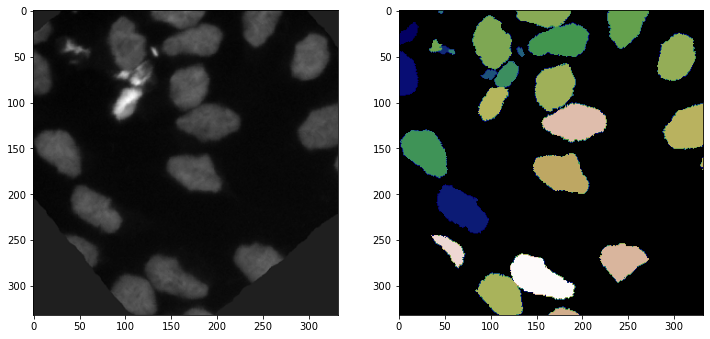

In [6]:
# repeatedly execute this cell to get different images
for image, label in data_train:
    break

label = np.squeeze(label, 0)
if prediction_type == "affinities":
    label = label[0] + label[1]

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')
plt.show()

Define our U-Net
==============
As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution. Our CNN used 'same' padding before, which assures that spatial dimensions are not reduced by the convolution operation. Unfortunately, this padding scheme renders the network location-aware, since it can learn to calculate the distance of most pixels in the image to the padded zeros at the image boundaries. This location awareness then leads to discontinuities at the stitching boundaries. Therefore we'll use 'valid' padding instead of 'same' padding.

Valid padding actually means that input filter maps are not padded at all and therefore the spatial dimensions of the filter maps reduce after every convolution. This leads to the network predicting smaller tiles than the ones that got fed into the network as you can see in the network summary below, e.g choosing the net_input_size = $[332,332]$, our output tile size will be $[148,148]$ with our defined UNet structure. Therefore the input tiles need to overlap such that the output tiles align.

In [7]:
torch.manual_seed(42)
d_factors = [[2,2],[2,2],[2,2],[2,2]]
net_input_size = [332,332]

net = torch.nn.Sequential(
    UNet(in_channels=1,
    num_fmaps=32,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='valid',
    num_fmaps_out=32,
    constant_upsample=False
    ),
    torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1, net_input_size[0], net_input_size[1]))

/home/xiaoyan/anaconda3/envs/07_instance_segmentation/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 330, 330]             320
              ReLU-2         [-1, 32, 330, 330]               0
            Conv2d-3         [-1, 32, 328, 328]           9,248
              ReLU-4         [-1, 32, 328, 328]               0
          ConvPass-5         [-1, 32, 328, 328]               0
         MaxPool2d-6         [-1, 32, 164, 164]               0
        Downsample-7         [-1, 32, 164, 164]               0
            Conv2d-8         [-1, 64, 162, 162]          18,496
              ReLU-9         [-1, 64, 162, 162]               0
           Conv2d-10         [-1, 64, 160, 160]          36,928
             ReLU-11         [-1, 64, 160, 160]               0
         ConvPass-12         [-1, 64, 160, 160]               0
        MaxPool2d-13           [-1, 64, 80, 80]               0
       Downsample-14           [-1, 64,

Training
=======

You already know the training loop from the other notebooks. For this execise we already trained a network like the one that you just defined for 60,000 training steps. You can load this CNN by executing the next cell.

In [8]:
net=torch.load("utils/unet_60000",map_location=device) #load checkpoint unet_60000

Postprocessing
=============

Here we first tile the input image and feed the tiles to the network to generate our predictions. Then the tiles are cropped and stitched to form the final embeddings. In the lecture you learned that U-Nets are shift equivariant only for shifts that are multiples of $f^l$, since our network does pooling with window size and stride $2$ and has $4$ pooling layers $f^l=2^4=16$. When stitching output crops of this U-Net whose spatial dimensions are not multiples of $16$ you might observe discontinuities at the stitching boundaries that lead to false splits. 

Play around with the crop_size and see yourself!

-17.576906 9.193424
average precision: 0.359375, precision: 0.3770491803278688, recall: 0.8846153846153846
true positives: 23, false positives: 38, false negatives: 3


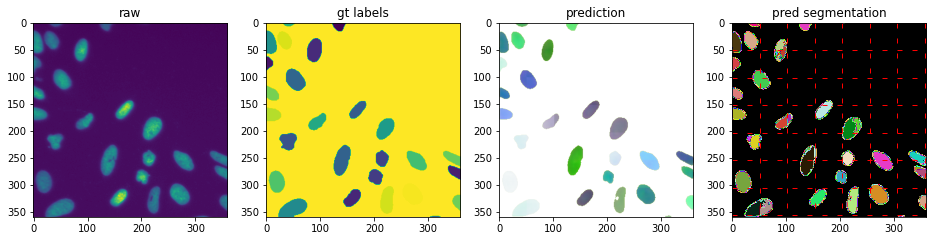

-14.81442 7.487599
average precision: 0.3953488372093023, precision: 0.425, recall: 0.85
true positives: 17, false positives: 23, false negatives: 3


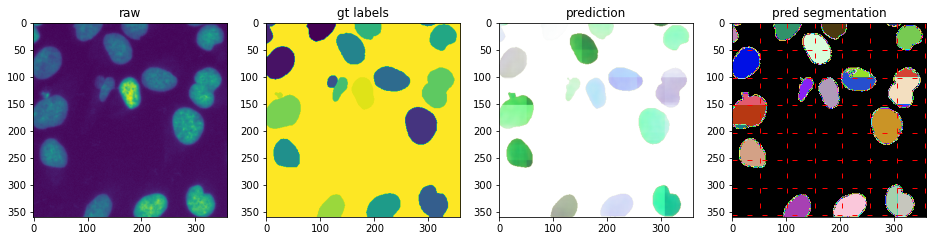

-17.6284 7.4118085
average precision: 0.45918367346938777, precision: 0.4891304347826087, recall: 0.8823529411764706
true positives: 45, false positives: 47, false negatives: 6


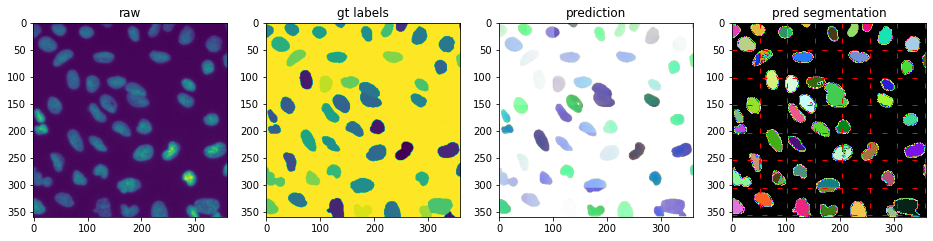

-14.800018 7.336467
average precision: 0.33962264150943394, precision: 0.34615384615384615, recall: 0.9473684210526315
true positives: 18, false positives: 34, false negatives: 1


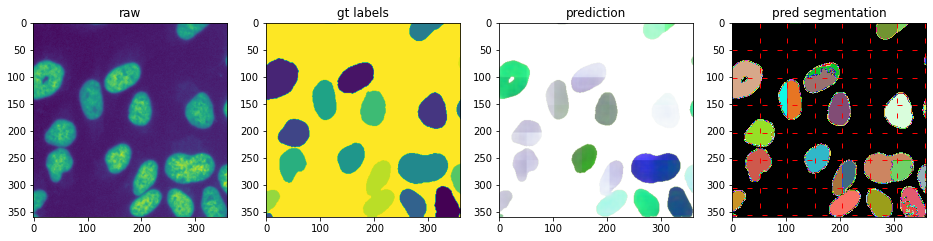

-17.861786 8.979134
average precision: 0.1237785016286645, precision: 0.20212765957446807, recall: 0.24203821656050956
true positives: 38, false positives: 150, false negatives: 119


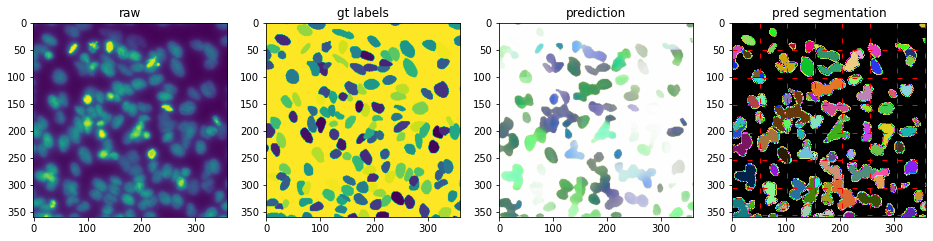

-15.57282 7.624934
average precision: 0.14516129032258066, precision: 0.15126050420168066, recall: 0.782608695652174
true positives: 18, false positives: 101, false negatives: 5


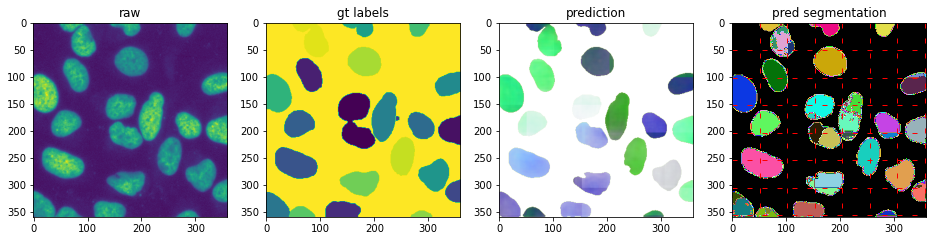

-14.570853 10.0640135
average precision: 0.55, precision: 0.5789473684210527, recall: 0.9166666666666666
true positives: 11, false positives: 8, false negatives: 1


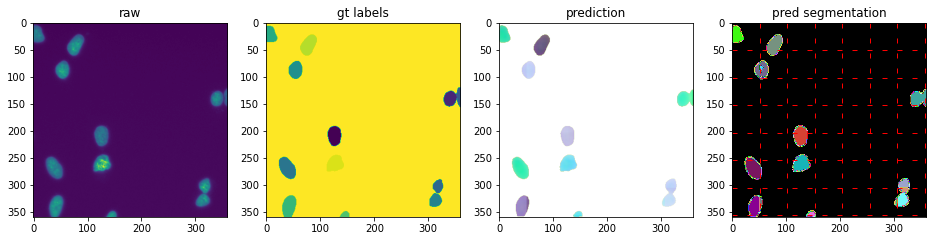

-17.17429 8.410475
average precision: 0.2857142857142857, precision: 0.32, recall: 0.7272727272727273
true positives: 16, false positives: 34, false negatives: 6


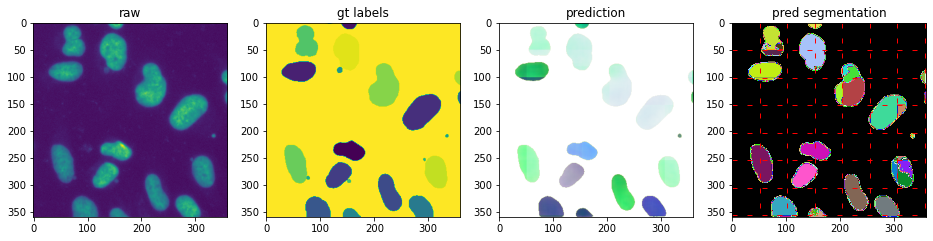

-15.807989 7.560253
average precision: 0.5517241379310345, precision: 0.64, recall: 0.8
true positives: 16, false positives: 9, false negatives: 4


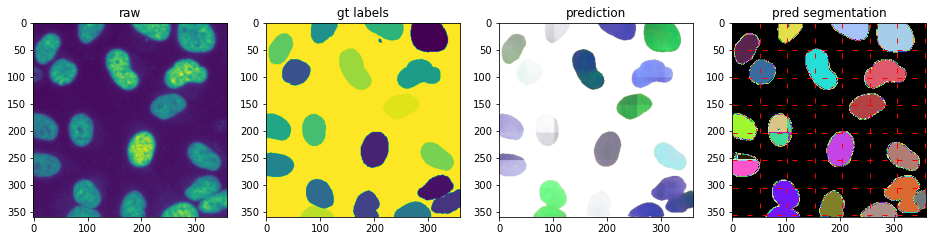

-16.138323 7.8863697
average precision: 0.1111111111111111, precision: 0.11320754716981132, recall: 0.8571428571428571
true positives: 6, false positives: 47, false negatives: 1


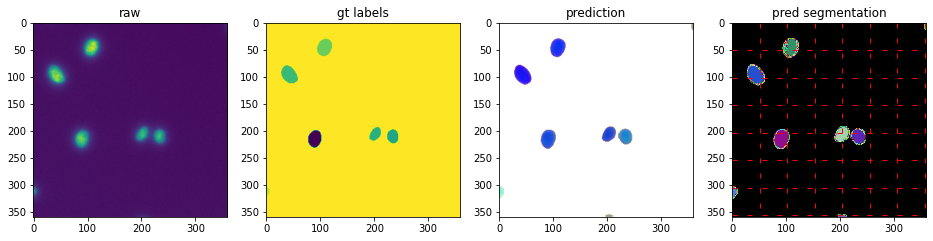

-16.795746 6.457844
average precision: 0.375, precision: 0.44680851063829785, recall: 0.7
true positives: 21, false positives: 26, false negatives: 9


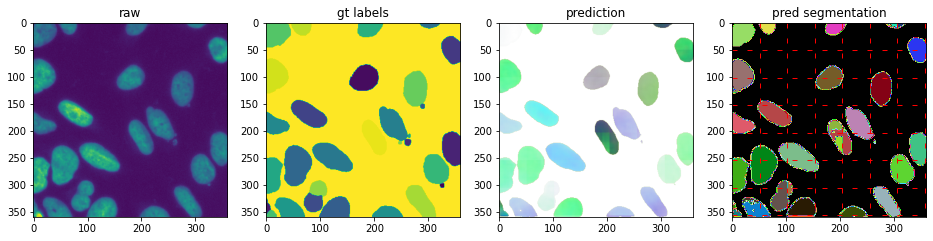

-18.357769 7.028355
average precision: 0.4148936170212766, precision: 0.42857142857142855, recall: 0.9285714285714286
true positives: 39, false positives: 52, false negatives: 3


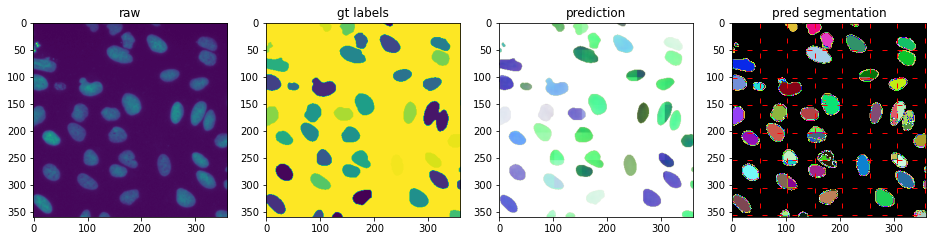

-17.786568 9.83171
average precision: 0.375, precision: 0.391304347826087, recall: 0.9
true positives: 36, false positives: 56, false negatives: 4


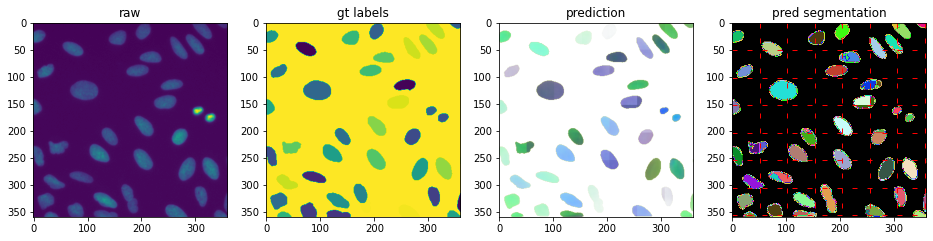

-17.206654 7.332538
average precision: 0.34782608695652173, precision: 0.37209302325581395, recall: 0.8421052631578947
true positives: 16, false positives: 27, false negatives: 3


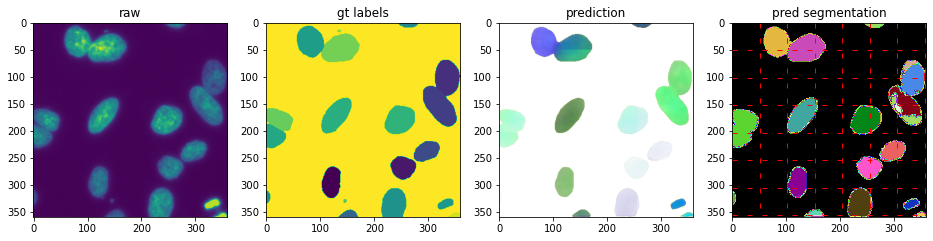

-18.099022 9.690673
average precision: 0.38461538461538464, precision: 0.4205607476635514, recall: 0.8181818181818182
true positives: 45, false positives: 62, false negatives: 10


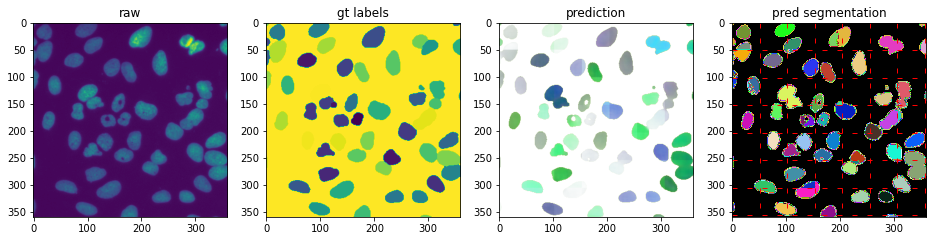

-15.906607 7.232965
average precision: 0.3793103448275862, precision: 0.4583333333333333, recall: 0.6875
true positives: 11, false positives: 13, false negatives: 5


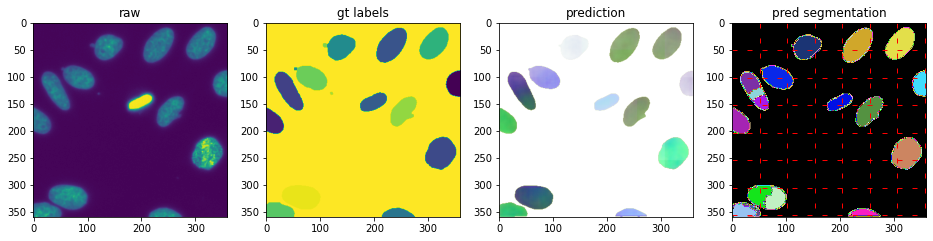

average precision on test set: 0.3498540570197856


In [9]:
%reload_ext autoreload
%autoreload 2
from utils.label import *
from utils.evaluate import *

crop_size =  [51,51] # to see discontinuties at the stitching boundaries, set the value not to be the multiples of 16
output_size = [148,148]
padding_size = 0
data_test = KaggleDSB_dataset(root, "test", prediction_type=prediction_type)
test_loader = DataLoader(data_test, batch_size=1)

# set flag
net.eval()
# set hyperparameters
prediction_type == "metric_learning"
fg_thresh = 0.7
seed_thresh = None
    
def unpad(pred, padding_size):
    return pred[padding_size:-padding_size,padding_size:-padding_size]

avg = 0.0
pad_top_left = (net_input_size[0]-output_size[0])//2
for idx, (image, gt_labels) in enumerate(test_loader):
    image = image.to(device)
    if crop_size:
        output_size = crop_size
    image_padded = F.pad(image, (pad_top_left,300,pad_top_left,300))
    H,W = image.shape[-2:]
    patched_pred = torch.zeros(1,4,image.shape[2]+200,image.shape[3]+200)
    for h in range(0, H, output_size[0]):
        for w in range(0, W, output_size[1]):
            image_tmp = image_padded[:,:,h:h+net_input_size[0],w:w+net_input_size[1]]
            pred = net(image_tmp)
            if crop_size:
                pred = pred[:,:,:crop_size[0],:crop_size[1]]
            patched_pred[:,:,h:h+pred.shape[2],w:w+pred.shape[3]] = pred
    pred = patched_pred[:,:,0:360,0:360]
    image = np.squeeze(image.cpu())
    gt_labels = np.squeeze(gt_labels)
    pred = np.squeeze(pred.cpu().detach().numpy(),0)
    #if prediction_type in ["three_class", "affinities","two_class","sdt"]:
    if padding_size and padding_size>0:
        pred = unpad(np.transpose(pred,(1,2,0)), padding_size)
        pred = np.transpose(pred,(2,0,1))
    labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx))
    avg += ap
    print(np.min(surface), np.max(surface))
    labelling = labelling.astype(np.uint8)
    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    if prediction_type == "metric_learning":
        surface = surface+np.abs(np.min(surface, axis=(1,2)))[:,np.newaxis,np.newaxis]
        surface /= np.max(surface, axis=(1,2))[:,np.newaxis,np.newaxis]
        surface = np.transpose(surface, (1,2,0))
    
    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    plt.imshow(np.squeeze(1.0-gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(1.0-surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap)
    bs = output_size[0]
    lw = 1
    for k in range(bs, labelling.shape[-1], bs):
        of = -0.5
        ax.plot([k+of, k+of], [0, labelling.shape[-2]-1], color='red', linestyle='--', dashes=(5, 10), linewidth=lw)
    for l in range(bs, labelling.shape[-2], bs):
        of = -0.5
        ax.plot([0, labelling.shape[-1]-1], [l+of, l+of], color='red', linestyle='--', dashes=(5, 10),linewidth=lw)

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))

You can copy the above code and change the crop_size =  $[64,64]$ and compare the different results.

-17.006498 9.793846
average precision: 0.6097560975609756, precision: 0.625, recall: 0.9615384615384616
true positives: 25, false positives: 15, false negatives: 1


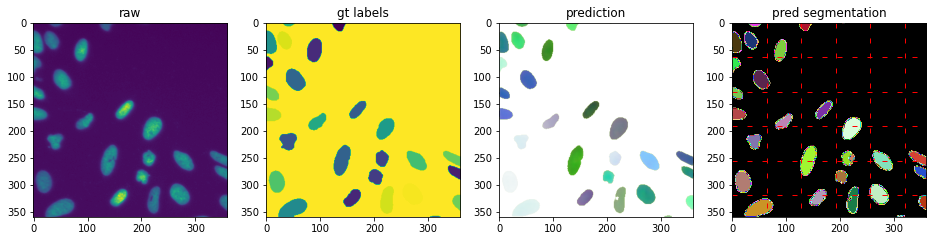

-13.983937 6.43727
average precision: 0.25862068965517243, precision: 0.2830188679245283, recall: 0.75
true positives: 15, false positives: 38, false negatives: 5


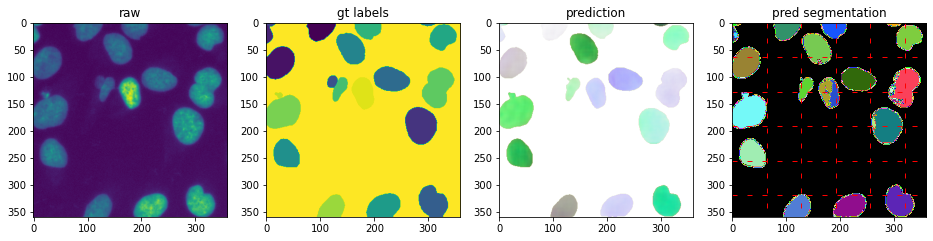

-17.136063 7.695108
average precision: 0.4845360824742268, precision: 0.5053763440860215, recall: 0.9215686274509803
true positives: 47, false positives: 46, false negatives: 4


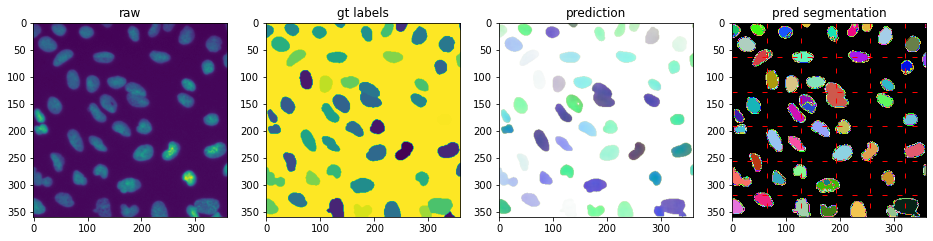

-15.12924 6.7779393
average precision: 0.2647058823529412, precision: 0.26865671641791045, recall: 0.9473684210526315
true positives: 18, false positives: 49, false negatives: 1


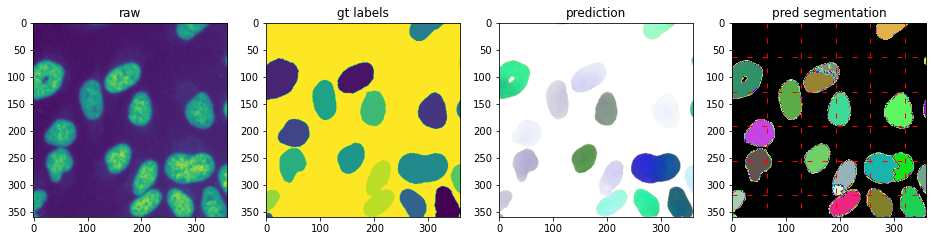

-17.944527 9.605392
average precision: 0.16842105263157894, precision: 0.2727272727272727, recall: 0.3057324840764331
true positives: 48, false positives: 128, false negatives: 109


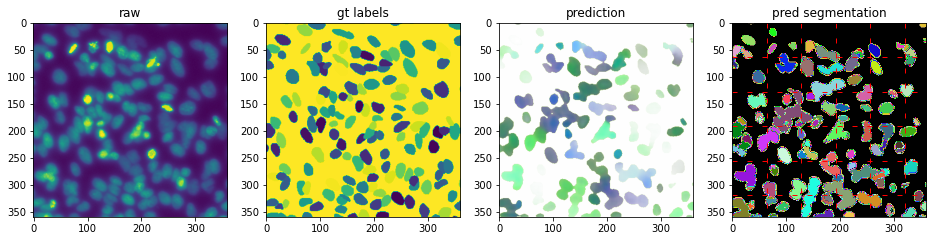

-15.616159 7.6452036
average precision: 0.3877551020408163, precision: 0.4222222222222222, recall: 0.8260869565217391
true positives: 19, false positives: 26, false negatives: 4


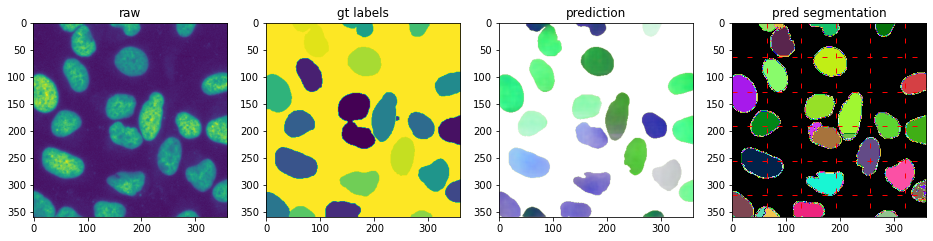

-14.570853 9.754647
average precision: 0.7333333333333333, precision: 0.7857142857142857, recall: 0.9166666666666666
true positives: 11, false positives: 3, false negatives: 1


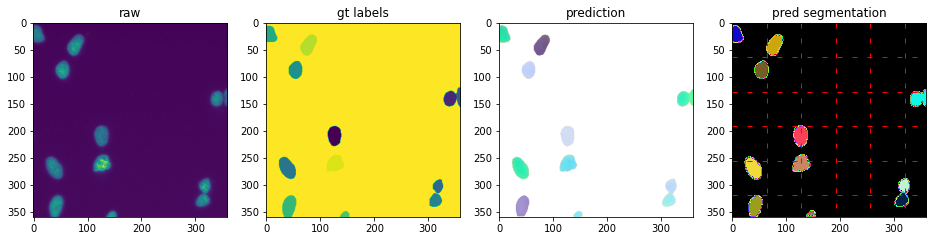

-15.878488 8.6148615
average precision: 0.5862068965517241, precision: 0.7083333333333334, recall: 0.7727272727272727
true positives: 17, false positives: 7, false negatives: 5


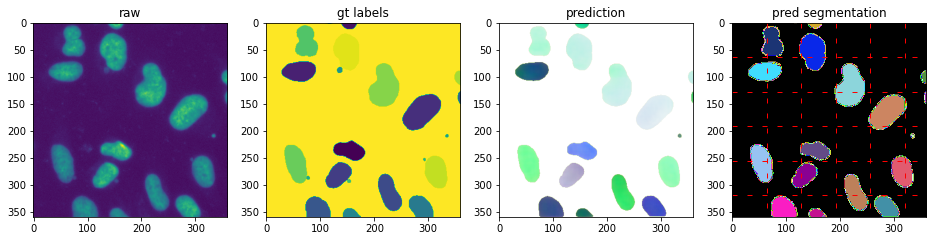

-15.803739 7.575297
average precision: 0.5, precision: 0.5294117647058824, recall: 0.9
true positives: 18, false positives: 16, false negatives: 2


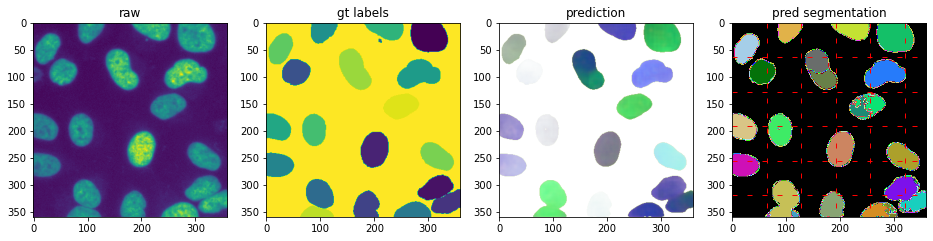

-16.080194 7.88223
average precision: 0.14634146341463414, precision: 0.15, recall: 0.8571428571428571
true positives: 6, false positives: 34, false negatives: 1


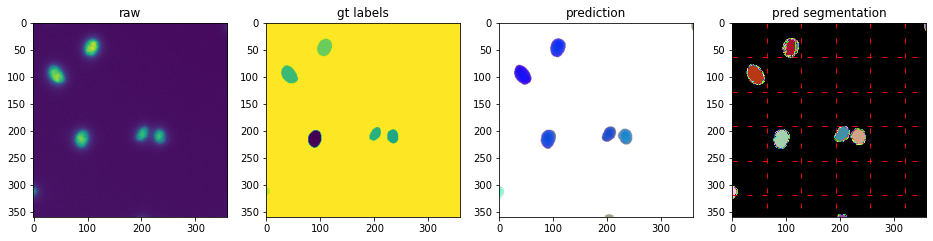

-16.568987 6.3486457
average precision: 0.29577464788732394, precision: 0.3387096774193548, recall: 0.7
true positives: 21, false positives: 41, false negatives: 9


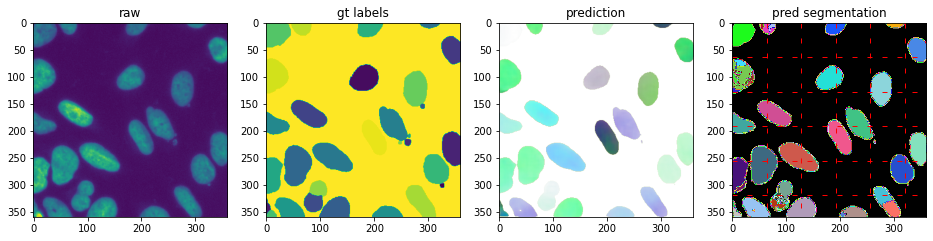

-18.523228 7.076861
average precision: 0.43956043956043955, precision: 0.449438202247191, recall: 0.9523809523809523
true positives: 40, false positives: 49, false negatives: 2


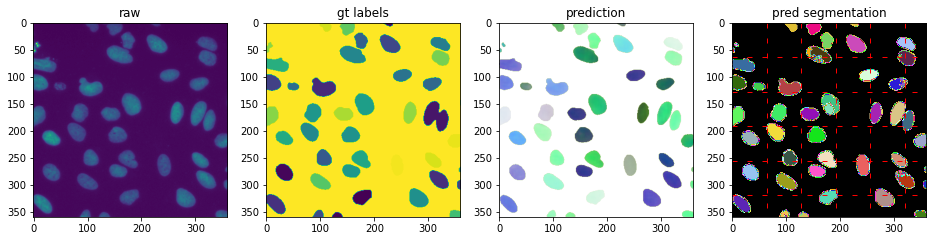

-18.04322 9.762231
average precision: 0.5714285714285714, precision: 0.6101694915254238, recall: 0.9
true positives: 36, false positives: 23, false negatives: 4


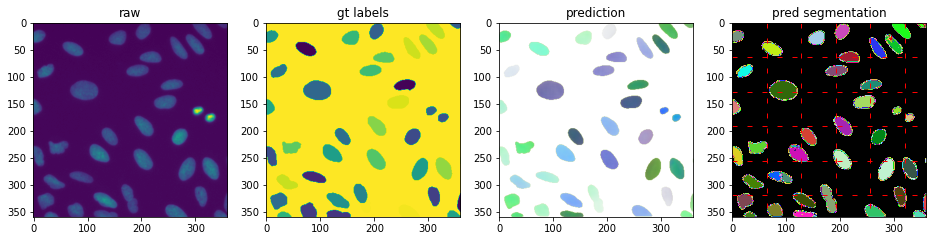

-16.80604 6.5382724
average precision: 0.38095238095238093, precision: 0.41025641025641024, recall: 0.8421052631578947
true positives: 16, false positives: 23, false negatives: 3


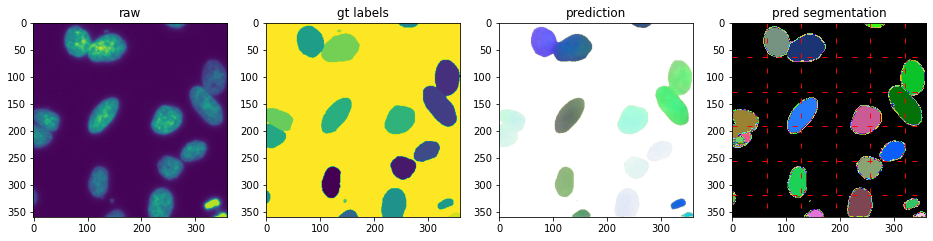

-18.083437 8.815237
average precision: 0.323943661971831, precision: 0.3458646616541353, recall: 0.8363636363636363
true positives: 46, false positives: 87, false negatives: 9


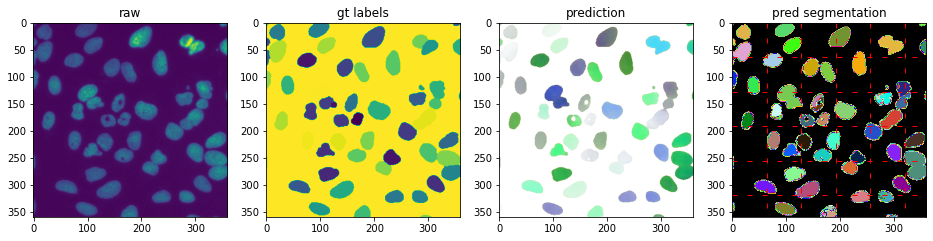

-16.147438 7.1672916
average precision: 0.36363636363636365, precision: 0.41379310344827586, recall: 0.75
true positives: 12, false positives: 17, false negatives: 4


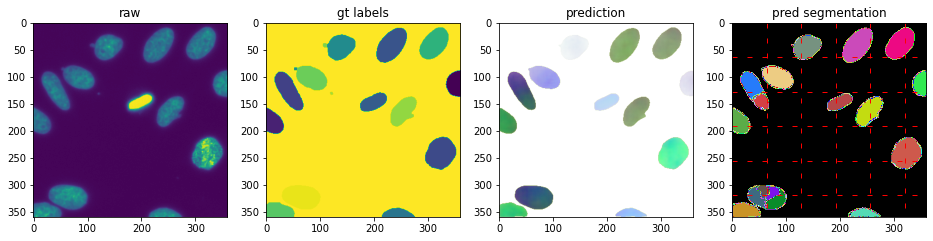

average precision on test set: 0.40718579159076956


In [11]:
%reload_ext autoreload
%autoreload 2
from utils.label import *
from utils.evaluate import *

crop_size =  [64,64] # set the value to be the multiples of 16
output_size = [148,148]
padding_size = 0
data_test = KaggleDSB_dataset(root, "test", prediction_type=prediction_type)
test_loader = DataLoader(data_test, batch_size=1)

# set flag
net.eval()
# set hyperparameters
prediction_type == "metric_learning"
fg_thresh = 0.7
seed_thresh = None
    
def unpad(pred, padding_size):
    return pred[padding_size:-padding_size,padding_size:-padding_size]

avg = 0.0
pad_top_left = (net_input_size[0]-output_size[0])//2
for idx, (image, gt_labels) in enumerate(test_loader):
    image = image.to(device)
    if crop_size:
        output_size = crop_size
    image_padded = F.pad(image, (pad_top_left,300,pad_top_left,300))
    H,W = image.shape[-2:]
    patched_pred = torch.zeros(1,4,image.shape[2]+200,image.shape[3]+200)
    for h in range(0, H, output_size[0]):
        for w in range(0, W, output_size[1]):
            image_tmp = image_padded[:,:,h:h+net_input_size[0],w:w+net_input_size[1]]
            pred = net(image_tmp)
            if crop_size:
                pred = pred[:,:,:crop_size[0],:crop_size[1]]
            patched_pred[:,:,h:h+pred.shape[2],w:w+pred.shape[3]] = pred
    pred = patched_pred[:,:,0:360,0:360]
    image = np.squeeze(image.cpu())
    gt_labels = np.squeeze(gt_labels)
    pred = np.squeeze(pred.cpu().detach().numpy(),0)
    #if prediction_type in ["three_class", "affinities","two_class","sdt"]:
    if padding_size and padding_size>0:
        pred = unpad(np.transpose(pred,(1,2,0)), padding_size)
        pred = np.transpose(pred,(2,0,1))
    labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx))
    avg += ap
    print(np.min(surface), np.max(surface))
    labelling = labelling.astype(np.uint8)
    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    if prediction_type == "metric_learning":
        surface = surface+np.abs(np.min(surface, axis=(1,2)))[:,np.newaxis,np.newaxis]
        surface /= np.max(surface, axis=(1,2))[:,np.newaxis,np.newaxis]
        surface = np.transpose(surface, (1,2,0))
    
    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    plt.imshow(np.squeeze(1.0-gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(1.0-surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap)
    bs = output_size[0]
    lw = 1
    for k in range(bs, labelling.shape[-1], bs):
        of = -0.5
        ax.plot([k+of, k+of], [0, labelling.shape[-2]-1], color='red', linestyle='--', dashes=(5, 10), linewidth=lw)
    for l in range(bs, labelling.shape[-2], bs):
        of = -0.5
        ax.plot([0, labelling.shape[-1]-1], [l+of, l+of], color='red', linestyle='--', dashes=(5, 10),linewidth=lw)

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))